In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
font = {'fontname':'Arial'}  
plt.rc('font',family='Arial')
import pickle
import random
from sklearn.metrics import roc_curve, auc, roc_auc_score
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

from ipynb.fs.full.Koazk_Similarity_Score_Algorithm import weights, similarity_score


In [2]:
p_aug_sequences = list(np.load('Total Data/aug_pos.npy',allow_pickle=True))

distribution_aug = []


for i in p_aug_sequences:
    distribution_aug=np.append(distribution_aug,similarity_score(i))
    

p_nonaug_sequences = list(np.load('Total Data/aug_neg.npy',allow_pickle=True))


p_distribution_nonaug = []


for i in p_nonaug_sequences:
    p_distribution_nonaug=np.append(p_distribution_nonaug,similarity_score(i))    

In [3]:
randoms=100000 
possible = ['a','t','c','g']
ran_sequences=[0]*randoms
for i in range(randoms):
    sequence=''.join(random.choices(possible, k=23))
    ran_sequences[i]=sequence

distribution_ran = []

    
for i in ran_sequences:
    distribution_ran=np.append(distribution_ran,similarity_score(i))

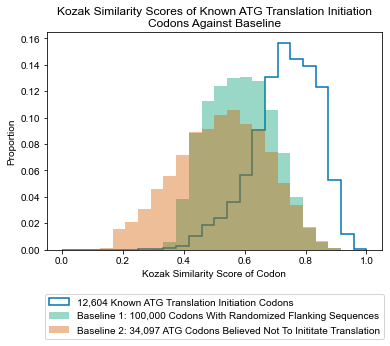

In [4]:

fig = plt.figure()
ax = fig.add_subplot(111)    
ax.hist(distribution_aug,bins = np.linspace(0,1,25),histtype=u'step',alpha=1,
           weights=np.ones(len(distribution_aug)) / len(distribution_aug),
          label = "12,604 Known ATG Translation Initiation Codons",linewidth=1.5)

ax.hist(distribution_ran,np.linspace(0,1,25),histtype=u'stepfilled',alpha=0.4,
           weights=np.ones(len(distribution_ran)) / len(distribution_ran),
          label = "Baseline 1: 100,000 Codons With Randomized Flanking Sequences",linewidth=1.5)

ax.hist(p_distribution_nonaug,np.linspace(0,1,25),histtype=u'stepfilled',alpha=0.4,
           weights=np.ones(len(p_distribution_nonaug)) / len(p_distribution_nonaug),
          label = "Baseline 2: 34,097 ATG Codons Believed Not To Inititate Translation",linewidth=1.5)


title = ax.set_title("\n".join(wrap('Kozak Similarity Scores of Known ATG Translation Initiation Codons Against Baseline', 60)))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.18))
plt.xlabel("Kozak Similarity Score of Codon")
plt.ylabel("Proportion")
plt.show()

#### Due to sampling strategy, results may marginally vary per run

In [5]:
values = np.arange(0.58,0.7,0.001)

runs = 1000


errors = []

subsets = []

for i in range(runs):
        distribution_nonaug= np.array(random.sample(list(p_distribution_nonaug),len(distribution_aug)))
        
        subsets.append(list(distribution_nonaug)+list(distribution_aug))

for val in values:
    error = [0]*runs
    for i in range(runs):
        distribution_nonaug= subsets[i][0:len(distribution_nonaug)]
        
        error[i] = (sum(distribution_nonaug>val)+sum(distribution_aug<val))/(len(distribution_nonaug)+len(distribution_aug))
        
    errors.append([np.mean(error),val])

# Finding Best Score Threshold to Miminize Model Classification Error

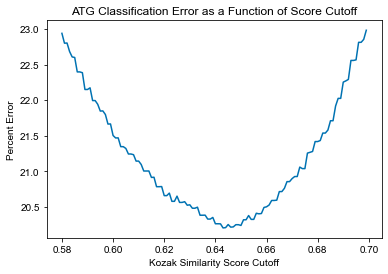

In [6]:
errors_ =[]

for i in errors:
    errors_.append(i[0]*100)

font = {'fontname':'Arial'}        
fig = plt.figure()
plt.plot(values, errors_)
plt.xlabel('Kozak Similarity Score Cutoff')
plt.ylabel('Percent Error')


plt.title('ATG Classification Error as a Function of Score Cutoff')
plt.show()

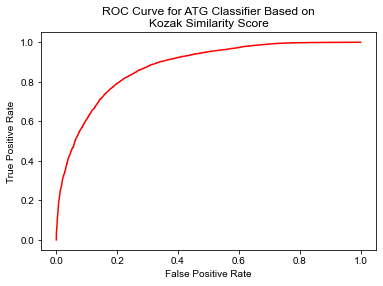

AUC: 0.876


In [7]:
cutoff=min(errors)[1]

distribution_nonaug= np.array(random.sample(list(p_distribution_nonaug),len(distribution_aug)))

total_aug_distribution=np.append(distribution_nonaug,distribution_aug)/(2*cutoff) #Normalizing Scores

true_classes=np.append(np.zeros(len(distribution_nonaug)),np.ones(len(distribution_aug)))

        
fpr, tpr, thresholds = roc_curve(true_classes, total_aug_distribution)
        
plt.plot(fpr, tpr,color='red')
plt.title("\n".join(wrap('ROC Curve for ATG Classifier Based on Kozak Similarity Score', 40)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
auc = roc_auc_score(true_classes, total_aug_distribution)

print('AUC: %.3f' % auc)

# Kozak Similarity Score as a Metric of ATG Codon Likelihood to Inititate Translation

In [8]:
cutoffs = np.arange(0,1,0.02)

runs = 1000

mean_proportions_translating = []


subsets = []

for i in range(runs):
        distribution_nonaug= np.array(random.sample(list(p_distribution_nonaug),len(distribution_aug)))
        
        subsets.append(list(distribution_nonaug)+list(distribution_aug))

for cutoff in cutoffs:
    proportions_translating = [0]*runs
    for i in range(runs):
        distribution_nonaug= subsets[i][0:len(distribution_nonaug)]
        
        proportions_translating[i]=sum(distribution_aug>cutoff)/(sum(distribution_aug>cutoff)+sum(distribution_nonaug>cutoff))
                
    mean_proportions_translating.append([np.mean(proportions_translating),cutoff])


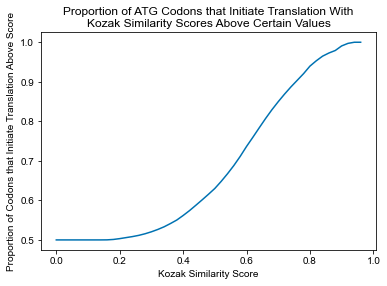

In [9]:
mean_proportions_translating_vals = [i[0] for i in mean_proportions_translating]


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cutoffs, mean_proportions_translating_vals)
plt.xlabel('Kozak Similarity Score')
plt.ylabel("\n".join(wrap('Proportion of Codons that Initiate Translation Above Score', 60)))

title = ax.set_title("\n".join(wrap('Proportion of ATG Codons that Initiate Translation With Kozak Similarity Scores Above Certain Values', 60)))
plt.show()